# Final Project "Detecting Hate Speech and Offensive Language on Twitter using Machine Learning"

## Step-1: Import Libraries

In [4]:
# import packages

import numpy as np
import pandas as pd
import tweepy
from tweepy import API
from tweepy import Cursor
from tweepy.streaming import StreamListener # With this we can listen to Tweets based on certain keywords and hashtags
from tweepy import OAuthHandler # Responsible for Authenticating for some of the authenticating credentials stored in TwitterCredentials.py file
from tweepy import Stream
from bokeh.layouts import column
from flask import request
from flask import Flask, render_template, session, redirect
from werkzeug.wrappers import Request, Response
from flask import Flask
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
import re
import threading
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import random
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob


# Initializing the three classifiers
svc = LinearSVC()
nb = MultinomialNB()
lr = LogisticRegression()
%matplotlib inline

## Step-2: Import and Load dataset

In [5]:
# Importing dataset
df = pd.read_csv('/Users/nitinkumar/Downloads/tweets_labelled_dataset.csv')
df = df.drop(df.columns[[0,1,2,3,4]],axis=1)
print(df.head(10))

# changing the column labels
df['class'] = df['class'].map({0:1 , 1:1, 2:0}) # change class label into (0, 1)
df.columns = ['Insult','Comment']

   class                                              tweet
0      2  !!! RT @mayasolovely: As a woman you shouldn't...
1      1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2      1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3      1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4      1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5      1  !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...
6      1  !!!!!!"@__BrighterDays: I can not just sit up ...
7      1  !!!!&#8220;@selfiequeenbri: cause I'm tired of...
8      1  " &amp; you might not get ya bitch back &amp; ...
9      1  " @rhythmixx_ :hobbies include: fighting Maria...


In [6]:
df_Tweets= df.sample(frac=1,axis=1).sample(frac=1).reset_index(drop=True)
print(df_Tweets.head(10))

                                             Comment  Insult
0  @truckpartstores Intended to get pics but didn...       0
1        RT @transtrenda: Okay okay but. Trans birds       0
2  @GossipCop Julie tell them crybaby blacks to g...       1
3  RT @JustDoItSlow: @vintage_monroe_ scary told ...       1
4       @Myalynn__x3 freeze bitch &#128514;&#128514;       1
5         Hahaha I see you niggah &#128064;&#128517;       1
6                       Yo bitch I had fun with that       1
7  RT @HootieGang4Ever: Des bitches swear dey fai...       1
8  Hope you find a bitch with some ass that satis...       1
9  RT @toddknife: Full @weakenednachos set (excep...       0


## Step-3 : Data Cleaning & Pre-Processing

First, let’s divide our dataset into features and label set. In our feature set, we will only use the text of the tweets as a feature. The corresponding label will be the sentiment of the tweet. 

Our dataset contains many irregularities so we need to remove them in order to have a clean dataset. The following script does that:

In [7]:
tok = WordPunctTokenizer()
# for removing usernames
ignore_list = ['rt', 'xa', 'da', 're']
pat1 = r'@[A-Za-z0-9]+'
# removing hyperlinks
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
# for reading the negation words correctly
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

# helper function to clean the text

def text_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped        
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) >= 1 and x not in ignore_list]
    return (" ".join(words)).strip()

In [8]:
clean_texts = []
for i in range(len(df_Tweets.Comment)):
    clean_texts.append(text_cleaner(df_Tweets['Comment'][i]))

In [9]:
# cleaned dataset

clean_df = pd.DataFrame(clean_texts, columns = ['text'])
clean_df['Insult'] = df_Tweets['Insult']
print(clean_df.head(10))

                                                text  Insult
0  intended to get pics but did not have time mus...       0
1                          okay okay but trans birds       0
2  julie tell them crybaby blacks to get someone ...       1
3  monroe scary told to come to her house to figh...       1
4                                     x freeze bitch       1
5                            hahaha i see you niggah       1
6                       yo bitch i had fun with that       1
7                     des bitches swear dey faithful       1
8  hope you find a bitch with some ass that satis...       1
9  full set except the last song from southern da...       0


## Step-4 : Defining Data Cleaning function through Word Cloud

In [10]:
ignore_list = ['rt', 'xa', 'da', 're']

In [11]:
neg_tweets = clean_df[clean_df['Insult']==1]
neg_string = []
for t in neg_tweets.text:
        neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

# Split the String into the words
tokens = word_tokenize(neg_string)
tokens = [w for w in tokens if not w in (stopwords.words('english') and ignore_list)]
random.shuffle(tokens)
lemma = nltk.wordnet.WordNetLemmatizer()
neg_string = []
for word in tokens:
    neg_string.append(lemma.lemmatize(word))
neg_string = pd.Series(neg_string).str.cat(sep=' ')

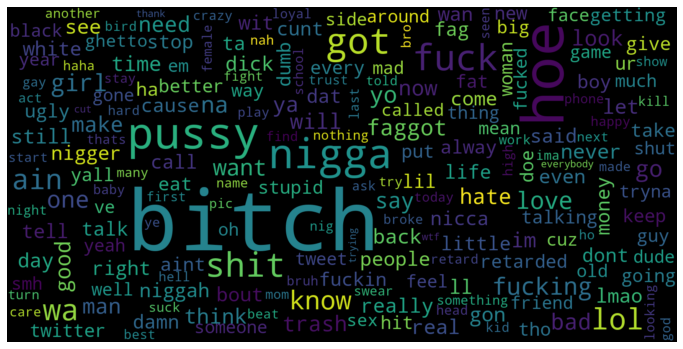

In [12]:
# Configuring word cloud
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Step-5 : Train / Dev / Test Split

Before we can train any model, we first consider how to split the data. Here I chose to split the data into three chunks: train, development, test. I referenced Andrew Ng's "deeplearning.ai" course on how to split the data.

**Train set**: The sample of data used for learning

**Development set (Hold-out cross-validation set)**: The sample of data used to tune the parameters of a classifier, and provide an unbiased evaluation of a model.

**Test set**: The sample of data used only to assess the performance of a final model.

Another approach is splitting the data into only train and test set, and run k-fold cross-validation on the training set, so that you can have an unbiased evaluation of a model. But considering the size of the data, I have decided to use the train set only to train a model, and evaluate on the dev set, so that I can quickly test different algorithms and run this process iteratively.

In [13]:
X = clean_df.text
y = clean_df.Insult

In [14]:
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(X, y, test_size=.2, random_state=0)

x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, 
                                                              test_size=.5, random_state=0)

In [15]:
print ("Train set has total {0} entries with {1:.2f}% neutral, {2:.2f}% negative".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print ("Validation set has total {0} entries with {1:.2f}% neutral, {2:.2f}% negative".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print ("Test set has total {0} entries with {1:.2f}% neutral, {2:.2f}% negative".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 19826 entries with 16.84% neutral, 83.16% negative
Validation set has total 2478 entries with 16.67% neutral, 83.33% negative
Test set has total 2479 entries with 16.58% neutral, 83.42% negative


## Step-6: Baseline- Sentiment Analysis using TextBlob¶

Another baseline I wanted to compare the validation results with is TextBlob. Textblob is a python library for processing textual data. Apart from other useful tools such as POS tagging, n-gram, The package has built-in sentiment classification. This is a so-called out-of-the-box sentiment analysis tool, and in addition to the null accuracy, I will also keep in mind of the accuracy I get from TextBlob sentiment analysis to see how my model is performing.

In [16]:
tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
tbpred = [0 if n < 0 else 1 for n in tbresult]

In [17]:
print(confusion_matrix(y_validation, tbpred, labels=[1,0]))

[[1383  682]
 [ 346   67]]


In [19]:
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['negative', 'neutral'],
                         columns=['predicted_negative','predicted_neutral'])
print("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print("-"*80)
print("Confusion Matrix\n")
print(confusion)
print("-"*80)
print("Classification Report\n")
print(classification_report(y_validation, tbpred))

Accuracy Score: 58.51%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_neutral
negative                1383                682
neutral                  346                 67
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

           0       0.09      0.16      0.12       413
           1       0.80      0.67      0.73      2065

    accuracy                           0.59      2478
   macro avg       0.44      0.42      0.42      2478
weighted avg       0.68      0.59      0.63      2478



TextBlob sentiment analysis yielded 58.51% accuracy on the validation set.

## Step-7 : Feature Extraction & Model Evaluation by using Tf-idf with n-gram range

We are going to extract features through Tf-Idf with ngram range so that we could evaluate our diffrent algorithm.

Below I define two functions to iteratively train on a different number of features, then check the accuracy of different classifier on the validation set.

### Accuracy Summary

In [20]:
# helper function - accuracy_summary

def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
        
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("-"*80)
    return accuracy

In [21]:
cvec = CountVectorizer()
lr = LogisticRegression()
tvec = TfidfVectorizer()
n_features = np.arange(17000,60000,5000)
# helper function - accuracy checker for n features
def nfeature_accuracy_checker(vectorizer=cvec, min_df=1,n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr
):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(min_df=min_df,stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([('vectorizer', vectorizer),('classifier', classifier)])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy))
    return result, checker_pipeline

### Accuracy using Tf-Idf on LinearSVC with **UNIGRAM**

In [22]:
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
svc_feature_result_ug, svc_u_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=svc)

RESULT FOR UNIGRAM WITH STOP WORDS

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


Validation result for 17000 features
null accuracy: 83.33%
accuracy score: 95.60%
model is 12.27% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 83.33%
accuracy score: 95.36%
model is 12.03% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 83.33%
accuracy score: 95.36%
model is 12.03% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 83.33%
accuracy score: 95.36%
model is 12.03

### Accuracy using Tf-Idf on LinearSVC with **BIGRAM**

In [23]:
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
svc_feature_result_bg, svc_b_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=svc,min_df=2,ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


Validation result for 17000 features
null accuracy: 83.33%
accuracy score: 95.04%
model is 11.70% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 83.33%
accuracy score: 95.04%
model is 11.70% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 83.33%
accuracy score: 95.04%
model is 11.70% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 83.33%
accuracy score: 95.08%
model is 11.74%

### Accuracy using Tf-Idf on LinearSVC with **TRIGRAM**

In [24]:
print ("RESULT FOR TRIGRAM WITH STOP WORDS\n")
svc_feature_result_tg, svc_t_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=svc,min_df=2,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


Validation result for 17000 features
null accuracy: 83.33%
accuracy score: 95.00%
model is 11.66% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 83.33%
accuracy score: 95.00%
model is 11.66% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 83.33%
accuracy score: 94.92%
model is 11.58% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 83.33%
accuracy score: 95.00%
model is 11.66

### Accuracy using Tf-Idf on Multinomial Naive Bayes with **UNIGRAM**

In [25]:
nb_feature_result_ug, nb_u_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=nb)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


Validation result for 17000 features
null accuracy: 83.33%
accuracy score: 85.43%
model is 2.10% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 83.33%
accuracy score: 85.27%
model is 1.94% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 83.33%
accuracy score: 85.27%
model is 1.94% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 83.33%
accuracy score: 85.27%
model is 1.94% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 37000 features
null accuracy: 83.33%
accuracy score: 85.27%
model is 1.94

### Accuracy using Tf-Idf on Multinomial Naive Bayes with **BIGRAM**

In [26]:
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
nb_feature_result_bg, nb_b_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=nb,min_df=2,ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


Validation result for 17000 features
null accuracy: 83.33%
accuracy score: 87.41%
model is 4.08% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 83.33%
accuracy score: 86.97%
model is 3.63% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 83.33%
accuracy score: 86.24%
model is 2.91% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 83.33%
accuracy score: 85.96%
model is 2.62% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 37000 features
null accuracy: 83.33%
a

### Accuracy using Tf-Idf on Multinomial Naive Bayes with **TRIGRAM**

In [27]:
print ("RESULT FOR TRIGRAM WITH STOP WORDS\n")
nb_feature_result_tg, nb_t_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=nb,min_df=2,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


Validation result for 17000 features
null accuracy: 83.33%
accuracy score: 87.33%
model is 4.00% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 83.33%
accuracy score: 86.92%
model is 3.59% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 83.33%
accuracy score: 86.52%
model is 3.19% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 83.33%
accuracy score: 86.24%
model is 2.91% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 37000 features
null accuracy: 83.33%


### Accuracy using Tf-Idf on Logistic Regression with **UNIGRAM**

In [28]:
import warnings
warnings.filterwarnings("ignore")

print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug, u_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=lr)

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 17000 features
null accuracy: 83.33%
accuracy score: 94.15%
model is 10.82% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 83.33%
accuracy score: 94.11%
model is 10.77% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 83.33%
accuracy score: 94.11%
model is 10.77% more accurate than null accuracy
--------------------------------------------------------------------------------
V

### Accuracy using Tf-Idf on Logistic Regression with **BIGRAM**

In [29]:
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg, b_checker_pipeline = nfeature_accuracy_checker(min_df=2,vectorizer=tvec,ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 17000 features
null accuracy: 83.33%
accuracy score: 93.30%
model is 9.97% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 83.33%
accuracy score: 93.06%
model is 9.73% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 83.33%
accuracy score: 92.82%
model is 9.48% more accurate than null accuracy
--------------------------------------------------------------------------------
Valid

### Accuracy using Tf-Idf on Logistic Regression with **TRIGRAM**

In [30]:
print ("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg, t_checker_pipeline = nfeature_accuracy_checker(min_df=2,vectorizer=tvec,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 17000 features
null accuracy: 83.33%
accuracy score: 93.26%
model is 9.93% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 83.33%
accuracy score: 93.02%
model is 9.69% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 83.33%
accuracy score: 92.98%
model is 9.64% more accurate than null accuracy
--------------------------------------------------------------------------------
Vali

### Accuracy Comparision on different model through ngram range

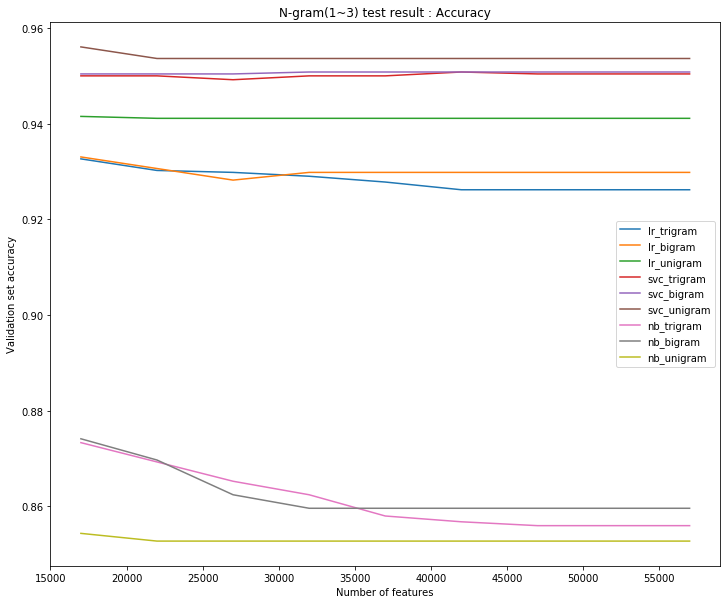

In [31]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy'])
svc_nfeatures_plot_tg = pd.DataFrame(svc_feature_result_tg,columns=['nfeatures','validation_accuracy'])
svc_nfeatures_plot_bg = pd.DataFrame(svc_feature_result_bg,columns=['nfeatures','validation_accuracy'])
svc_nfeatures_plot_ug = pd.DataFrame(svc_feature_result_ug,columns=['nfeatures','validation_accuracy'])
nb_nfeatures_plot_tg = pd.DataFrame(nb_feature_result_tg,columns=['nfeatures','validation_accuracy'])
nb_nfeatures_plot_bg = pd.DataFrame(nb_feature_result_bg,columns=['nfeatures','validation_accuracy'])
nb_nfeatures_plot_ug = pd.DataFrame(nb_feature_result_ug,columns=['nfeatures','validation_accuracy'])

plt.figure(figsize=(12,10))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='lr_trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='lr_bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='lr_unigram')
plt.plot(svc_nfeatures_plot_tg.nfeatures, svc_nfeatures_plot_tg.validation_accuracy,label='svc_trigram')
plt.plot(svc_nfeatures_plot_bg.nfeatures, svc_nfeatures_plot_bg.validation_accuracy,label='svc_bigram')
plt.plot(svc_nfeatures_plot_ug.nfeatures, svc_nfeatures_plot_ug.validation_accuracy, label='svc_unigram')
plt.plot(nb_nfeatures_plot_tg.nfeatures, nb_nfeatures_plot_tg.validation_accuracy,label='nb_trigram')
plt.plot(nb_nfeatures_plot_bg.nfeatures, nb_nfeatures_plot_bg.validation_accuracy,label='nb_bigram')
plt.plot(nb_nfeatures_plot_ug.nfeatures, nb_nfeatures_plot_ug.validation_accuracy, label='nb_unigram')

plt.title("N-gram(1~3) test result : Accuracy")

plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

### LOGISTIC REGRESSION W.R.T REGULARIZATION PARAMETER C AND VARIOUS OPTIMIZATION ALGORITHMS (SOLVERS)FOR THE FEATURES: N-GRAM RANGE 1-3 AND TFIDF NORMALIZATION L2

In [32]:
cvec = CountVectorizer()
lr = LogisticRegression()
stop_words = (stopwords.words('english'))
tvec = TfidfVectorizer()
n_features = np.arange(17000,60000,5000)
# helper function - accuracy checker for n features
def nfeature_accuracy_checker(vectorizer=cvec, min_df=1,n_features=n_features, stop_words=stop_words, ngram_range=(1, 3), classifier=lr
):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(min_df=min_df,stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([('vectorizer', vectorizer),('classifier', classifier)])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy))
    return result, checker_pipeline

#### C=10.0, Solver='liblinear'

In [33]:
import warnings
warnings.filterwarnings("ignore")

print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug, u_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=LogisticRegression(C=10.0,solver='liblinear'))

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 17000 features
null accuracy: 83.33%
accuracy score: 95.20%
model is 11.86% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 83.33%
accuracy score: 95.08%
model is 11.74% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 83.33%
accuracy score: 95.04%
model is 11.70% more accurate than null accuracy
----------------------------------------------------------------------------

#### C=10.0, Solver='newton-cg'

In [34]:
import warnings
warnings.filterwarnings("ignore")

print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug, u_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=LogisticRegression(C=10.0,solver='newton-cg'))

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 17000 features
null accuracy: 83.33%
accuracy score: 95.20%
model is 11.86% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 83.33%
accuracy score: 95.08%
model is 11.74% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 83.33%
accuracy score: 95.04%
model is 11.70% more accurate than null accuracy
----------------------------------------------------------------------------

#### C=10.0, Solver='saga'

In [35]:
import warnings
warnings.filterwarnings("ignore")

print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug, u_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=LogisticRegression(C=10.0,solver='saga'))

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 17000 features
null accuracy: 83.33%
accuracy score: 95.20%
model is 11.86% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 83.33%
accuracy score: 95.08%
model is 11.74% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 83.33%
accuracy score: 95.04%
model is 11.70% more accurate than null accuracy
--------------------------------------------------------------------------------


#### C=100.0, Solver='liblinear'

In [36]:
import warnings
warnings.filterwarnings("ignore")

print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug, u_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=LogisticRegression(C=100.0,solver='liblinear'))

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 17000 features
null accuracy: 83.33%
accuracy score: 94.79%
model is 11.46% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 83.33%
accuracy score: 94.83%
model is 11.50% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 83.33%
accuracy score: 94.92%
model is 11.58% more accurate than null accuracy
---------------------------------------------------------------------------

#### C=100.0, Solver='newton-cg'

In [37]:
import warnings
warnings.filterwarnings("ignore")

print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug, u_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=LogisticRegression(C=100.0,solver='newton-cg'))

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 17000 features
null accuracy: 83.33%
accuracy score: 94.79%
model is 11.46% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 83.33%
accuracy score: 94.87%
model is 11.54% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 83.33%
accuracy score: 94.96%
model is 11.62% more accurate than null accuracy
---------------------------------------------------------------------------

#### C=100.0, Solver='saga'

In [38]:
import warnings
warnings.filterwarnings("ignore")

print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug, u_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=LogisticRegression(C=100.0,solver='saga'))

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 17000 features
null accuracy: 83.33%
accuracy score: 94.87%
model is 11.54% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 83.33%
accuracy score: 94.79%
model is 11.46% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 83.33%
accuracy score: 94.92%
model is 11.58% more accurate than null accuracy
--------------------------------------------------------------------------------

### RESULTS AFTER TUNING NAIVE BAYES W.R.T SMOOTHING PRIOR α FOR THE FEATURES: N-GRAM RANGE (1, 3) AND TFIDF NORMALIZATION L2

In [39]:

cvec = CountVectorizer()
nb = MultinomialNB()
stop_words = (stopwords.words('english'))
tvec = TfidfVectorizer()
n_features = np.arange(17000,60000,5000)
# helper function - accuracy checker for n features
def nfeature_accuracy_checker(vectorizer=cvec, min_df=1,n_features=n_features, stop_words=stop_words, ngram_range=(1, 3), classifier=lr
):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(min_df=min_df,stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([('vectorizer', vectorizer),('classifier', classifier)])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy))
    return result, checker_pipeline

#### Alpha = 0.01

In [40]:
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
nb_feature_result_ug, nb_u_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=MultinomialNB(alpha=0.01),ngram_range=(1, 3))

RESULT FOR UNIGRAM WITH STOP WORDS

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)


Validation result for 17000 features
null accuracy: 83.33%
accuracy score: 91.04%
model is 7.71% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 83.33%
accuracy score: 90.96%
model is 7.63% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 83.33%
accuracy score: 91.04%
model is 7.71% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 83.33%
accuracy score: 90.84%
model is 7.51% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 37000 features
null accuracy: 83.33%

#### Alpha = 0.1

In [41]:
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
nb_feature_result_ug, nb_u_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=MultinomialNB(alpha=0.1),ngram_range=(1, 3))

RESULT FOR UNIGRAM WITH STOP WORDS

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)


Validation result for 17000 features
null accuracy: 83.33%
accuracy score: 90.60%
model is 7.26% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 83.33%
accuracy score: 90.56%
model is 7.22% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 83.33%
accuracy score: 90.68%
model is 7.34% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 83.33%
accuracy score: 90.52%
model is 7.18% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 37000 features
null accuracy: 83.33%


#### Alpha = 1.0

In [42]:
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
nb_feature_result_ug, nb_u_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=MultinomialNB(alpha=1.0),ngram_range=(1, 3))

RESULT FOR UNIGRAM WITH STOP WORDS

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


Validation result for 17000 features
null accuracy: 83.33%
accuracy score: 87.49%
model is 4.16% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 83.33%
accuracy score: 87.29%
model is 3.95% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 83.33%
accuracy score: 86.92%
model is 3.59% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 83.33%
accuracy score: 86.44%
model is 3.11% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 37000 features
null accuracy: 83.33%


#### Alpha = 10.0

In [43]:
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
nb_feature_result_ug, nb_u_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=MultinomialNB(alpha=10.0),ngram_range=(1, 3))

RESULT FOR UNIGRAM WITH STOP WORDS

MultinomialNB(alpha=10.0, class_prior=None, fit_prior=True)


Validation result for 17000 features
null accuracy: 83.33%
accuracy score: 83.41%
model is 0.08% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 83.33%
accuracy score: 83.41%
model is 0.08% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 83.33%
accuracy score: 83.33%
model has the same accuracy with the null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 83.33%
accuracy score: 83.33%
model has the same accuracy with the null accuracy
--------------------------------------------------------------------------------
Validation result for 37000 features
null accuracy: 

### Performance Comparision on accuracy of different model

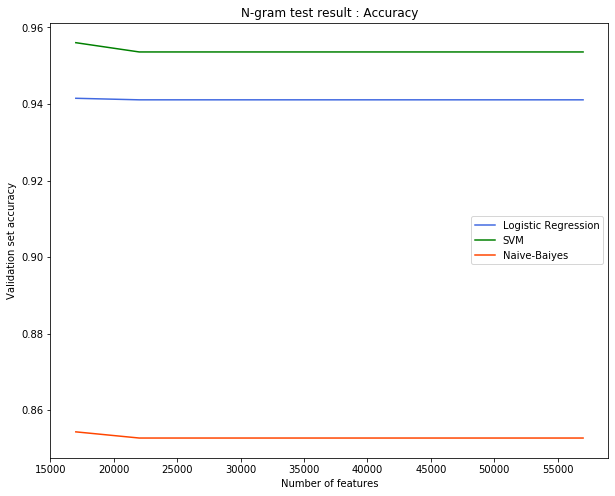

In [44]:
nfeatures_plot_ugt = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy'])
svc_nfeatures_plot_ugt = pd.DataFrame(svc_feature_result_ug,columns=['nfeatures','validation_accuracy'])
nb_nfeatures_plot_ugt = pd.DataFrame(nb_feature_result_ug,columns=['nfeatures','validation_accuracy'])

plt.figure(figsize=(10,8))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy,label='Logistic Regression',color='royalblue')
plt.plot(svc_nfeatures_plot_ug.nfeatures, svc_nfeatures_plot_ug.validation_accuracy,label='SVM', color='green')
plt.plot(nb_nfeatures_plot_ug.nfeatures, nb_nfeatures_plot_ug.validation_accuracy,label='Naive-Baiyes',color='orangered')

plt.title("N-gram test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

## Step-7 : Finally we'll select Logistic Regression for a final Evaluation

In [50]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['neutral', 'negative'],
                         columns=['predicted_neutral','predicted_negative'])
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("-"*80)
    print("Confusion Matrix\n")
    print(confusion)
    print("-"*80)
    print("Classification Report\n")
    print(classification_report(y_test, y_pred, target_names=['neutral','negative']))

In [51]:
%%time
ug_cvec = CountVectorizer(max_features=80000,ngram_range=(1, 3))
ug_pipeline = Pipeline([
        ('vectorizer', ug_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(ug_pipeline, x_train, y_train, x_validation, y_validation)

null accuracy: 83.33%
accuracy score: 95.84%
model is 12.51% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_neutral  predicted_negative
neutral                 376                  37
negative                 66                1999
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

     neutral       0.85      0.91      0.88       413
    negative       0.98      0.97      0.97      2065

    accuracy                           0.96      2478
   macro avg       0.92      0.94      0.93      2478
weighted avg       0.96      0.96      0.96      2478

CPU times: user 3.85 s, sys: 87.2 ms, total: 3.94 s
Wall time: 2.5 s
